In [6]:
# Importing the libraries 
import pandas as pd 
import missingno as msno

In [40]:
# todo: set as env variable for raw main table
rootpath = "/hdd/work/d4ad_standardization/"
filepath = "./D4AD_Standardization/data/raw/etpl_all_programsJune3.xls"

columns = [
    "NAME",
    "NAME_1",
    "DESCRIPTION",
    "PREREQUISITES",
    "FEATURESDESCRIPTION",
    "STREET1",
    "CITY",
    "STATE",
    "ZIP",
    "WEBSITE",
    "COUNTY",
    "NONGOVAPPROVAL",
    "STATECOMMENTS",
    "CIPCODE"
]

df = pd.read_excel(rootpath + filepath, usecols=columns)

In [41]:
df.shape, df.columns

((24667, 14),
 Index(['NAME', 'STREET1', 'CITY', 'STATE', 'ZIP', 'WEBSITE', 'COUNTY',
        'NONGOVAPPROVAL', 'STATECOMMENTS', 'CIPCODE', 'PREREQUISITES',
        'DESCRIPTION', 'FEATURESDESCRIPTION', 'NAME_1'],
       dtype='object'))

<AxesSubplot:>

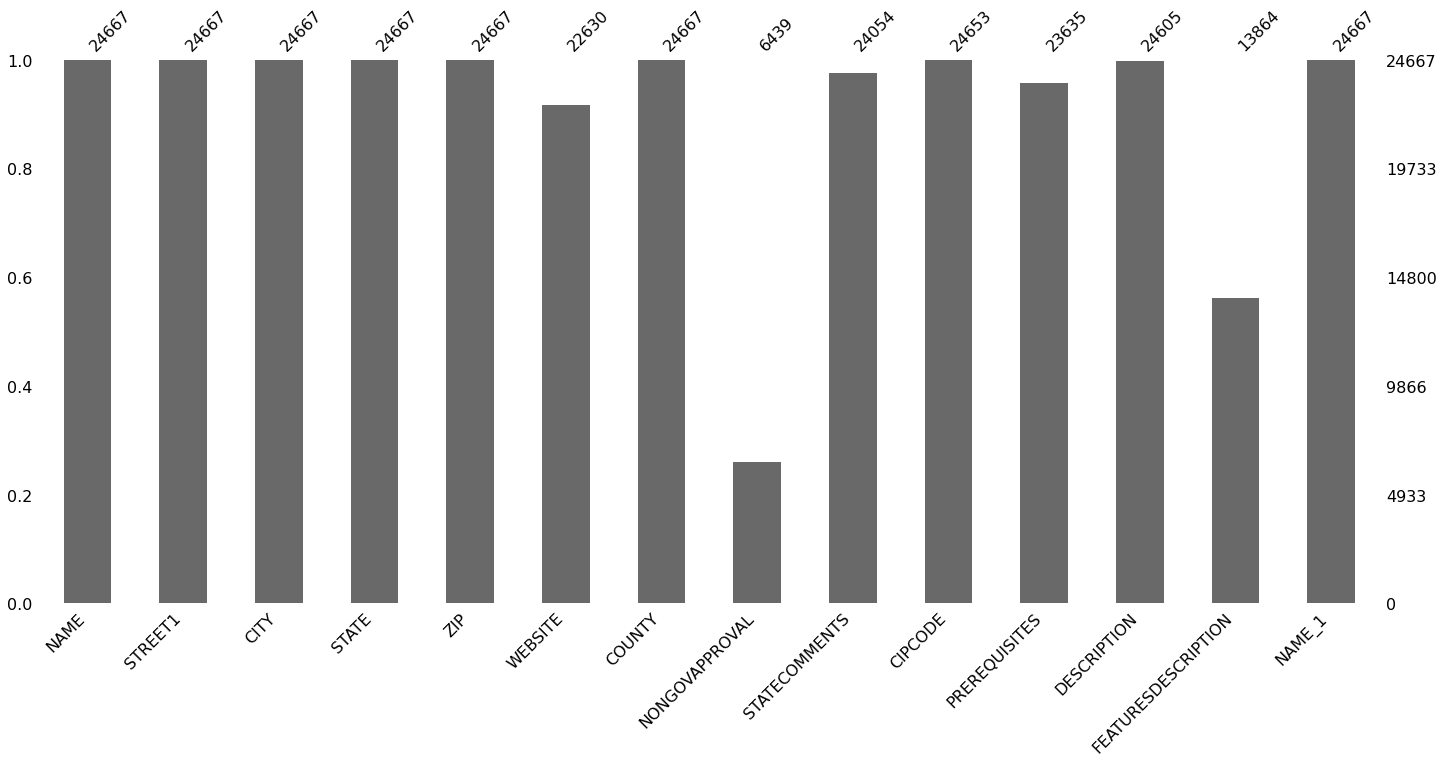

In [42]:
msno.bar(df)

<AxesSubplot:>

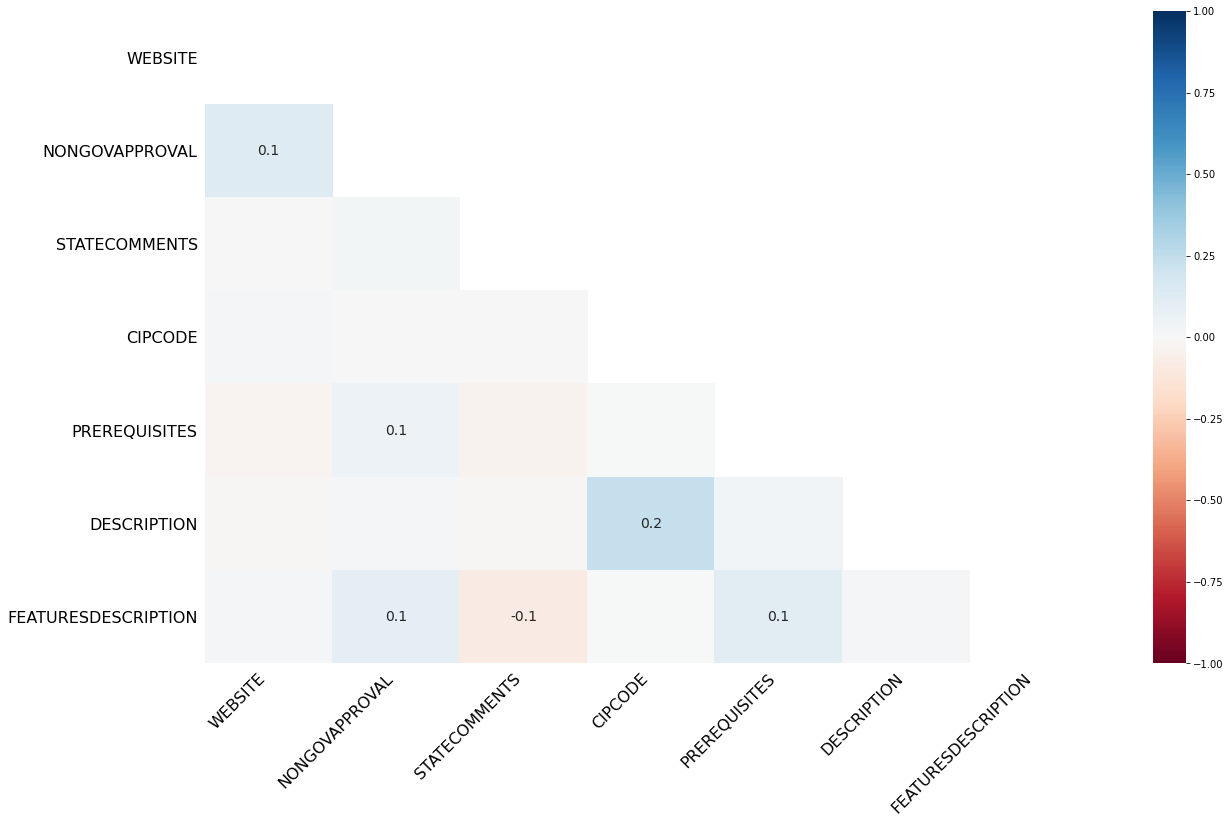

In [43]:
msno.heatmap(df)

<AxesSubplot:>

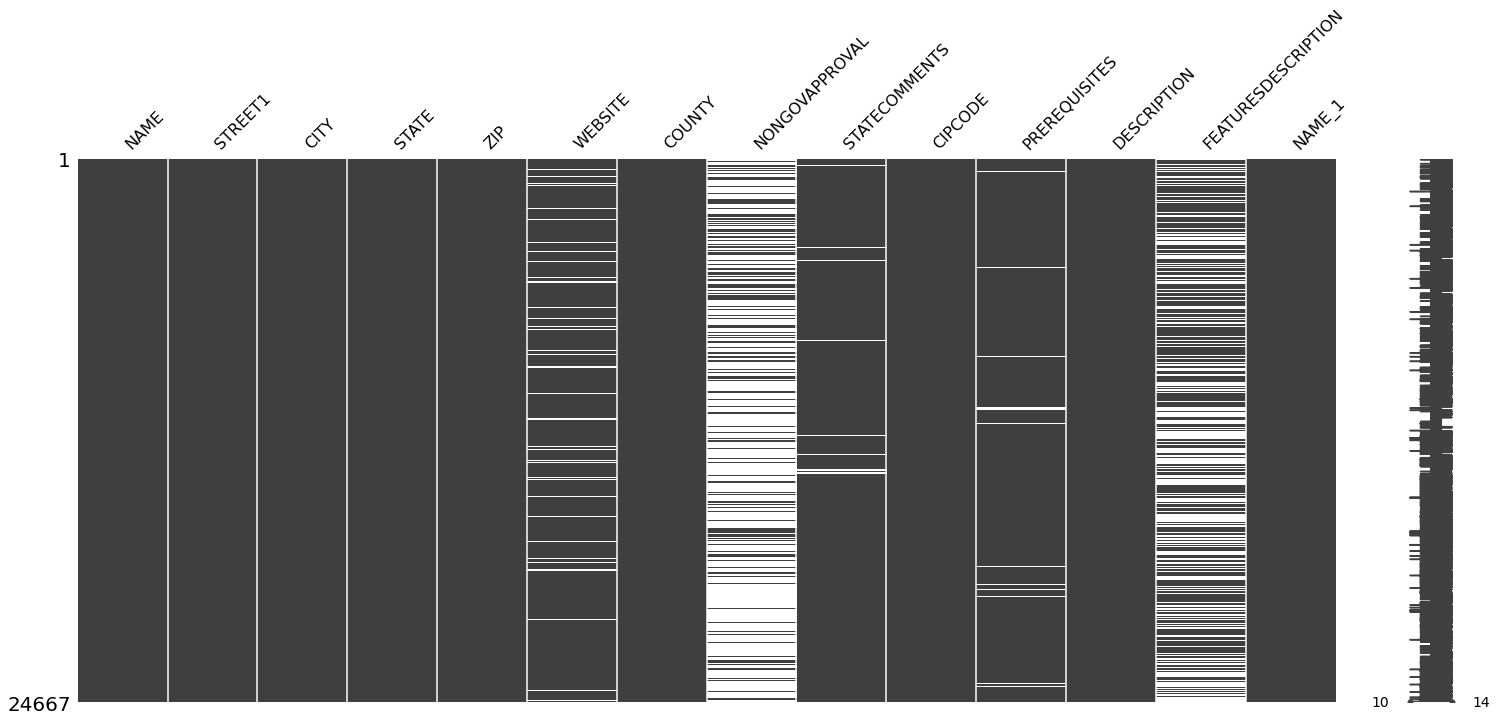

In [44]:
msno.matrix(df) 

### Okay so the above are fields that strongly overlap with VMWare's scope as well.

I suspect every field except for `street1`, `CITY`, `STATE`, `ZIP` and `COUNTY` needs standardization or imputation. Imputation was not mentioned in the Kwamata contract but only `NONGOVAPPROVAL` needs it.

Note that this does not include `COURSETYPE`/`STATUS` and `PROGRAMTYPE` that indicate online, hybird, in-person offerings.


#### Strategy Discussion
A) Standardization
* `NAME`: Can do rule matcher and/or build up statistical matcher to parse out `NAME`; somehow identify failed solutions, push to Google Places API for `URL`, `NAME`. Could, also, work backwards, for those entries w no website we fetch, for about 2,030ish and backfill. `STREET1`, `CITY`, `STATE`, `ZIP` appear good. 
 * Is it cheaper to run on 24,667 names?
 * Identify what needs to be removed, build up with a statistical matcher as well
* `NAME_1`: This is program name. This requires removal of abbreviations, `PREREQUISITES`, etc. from title. This is a removal type of standardization. Probably dependent on antecedent work. <-- this is a kind of sequence problem too
* `PREREQUISITES`: Have RuleMatcher for splitting the field into actual prereqs, unknown number of them. Mention possible approach here: https://support.prodi.gy/t/classification-with-unknown-number-of-classes/3302. Let whatever  approach I take for building up a set of classes from extract short text be called _Process A_ for category `PREREQUISITES`. This creates a lookup table for SQL REPLACE for continued data updates.
* `DESCRIPTION`: Apply _Process A_ from `PREREQUISITES`; Apply _Process A_ for category *Abbreviation* to `DESCRIPTION`.
* `FEATURESDESCRIPTION`: Repeats results from `DESCRIPTION` (no "extra" work)

B) Imputation
* `NONGOVAPPROVAL`: This is interesting, a) need to build up the classes, then I think I can use imputation to fill in some of rest, include an accuracy rating and spot check them (can I?). This also can be inferred from surrounding descriptions. This also relates to `COURSETYPE`, `PROGRAMTYPE`, `COURSESTATUS`
* 

C) Disqualified Progrms (extra)
* `STATECOMMENTS`: Do simple Text classification for StateComments, Disqualified or Not <-- statistical rule matcher?


#### Strategy Implementation
* **Process** A is key for most of this. Prodigy is pretty cool but I don't see a way to easily annotate short text of unknown classes. Therefore, in the interest of time, I should:
 * A) Finish the prereq extractor and generate the list of prereqs. This will be pretty big. Generalize to take in a matcher (non-content or otherwise) to allow it to generate content. This allows it to work on abbreviations in `DESCRIPTION` too if a content matcher is provided as opposed to a non-content matcher.
 * B) Figure out the best way to cluster the content such that the clusters appear robust and very similar to another. Things to think about: context of content, character, token content representation, granuality (fine)
 * C) From clusters, threshold, generate classes, write out a simple text file. From here I should be able to run this through an annotator.

I think I'm going to need to run triz on this part for an efficient way forward, but it can be done.
 * quick thought: sort by CIPCODE, first 3 alpabetical letter, assume first letters more likely to be the same than following letters, paste into spreadsheet, scroll, add class, scroll, copy out classes, take out newlines, BOOM. Assumes a lot of repetition

* See: Abbreviation detection (seems to assume both co-occur) https://github.com/philgooch/abbreviation-extraction
* See: Shorttext clustering, https://shorttext.readthedocs.io/en/latest/intro.html
* See: GDDM, https://github.com/rwalk/gsdmm and https://stackoverflow.com/questions/62191065/gsdmm-convergence-of-clusters-short-text-clustering with https://stackoverflow.com/a/62331941/3662899
* See: SnorkelJ for label annotation, https://www.snorkel.org/ <-- requires labels known in advance
* **See**: https://cilvr.cs.nyu.edu/diglib/lsml/lecture12_active.pdf **Directly talks about active labeling**


#### Fields that don't overlap
* Instruction Modalty (this is coursetype, status)
* DOL-Type (?)
* CIPCODE


